In [336]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

### 1) Importer le dataset

In [337]:
dataset=pd.read_csv("Housing.csv")
dataset = pd.DataFrame(dataset)
dataset

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


### 2) Nettoyage de Data

In [338]:
# MAP yes/no → 1/0
yes_no_map = {"yes": 1, "no": 0}

cols_yes_no = [
    "mainroad",
    "guestroom",
    "basement",
    "hotwaterheating",
    "airconditioning",
    "prefarea"
]

dataset[cols_yes_no] = dataset[cols_yes_no].replace(yes_no_map)

# MAP furnishingstatus → 2/1/0
furn_map = {
    "furnished": 2,
    "semi-furnished": 1,
    "unfurnished": 0
}

dataset["furnishingstatus"] = dataset["furnishingstatus"].replace(furn_map)

# Extraire X valeurs
x = dataset[[
    "area","bedrooms","bathrooms","stories",
    "mainroad","guestroom","basement","hotwaterheating",
    "airconditioning","parking","prefarea","furnishingstatus"
]].values

# dataset.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_16172\2329771983.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset[cols_yes_no] = dataset[cols_yes_no].replace(yes_no_map)
C:\Users\hp\AppData\Local\Temp\ipykernel_16172\2329771983.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset["furnishingstatus"] = dataset["furnishingstatus"].replace(furn_map)


### 3) Définition des x et y initial

In [339]:
#Création de X et Y
X = dataset[["area","bedrooms","bathrooms","stories","mainroad","guestroom","basement","hotwaterheating","airconditioning","parking","prefarea","furnishingstatus"]].values
y = dataset[["price"]].values 

# x = x.reshape(x.shape[0],3)
y = y.reshape(y.shape[0],1)

### 5) Séparation des données en données d'entrainement et de test

In [341]:
#data split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 6) Fonction de normalisation from scratch

In [342]:
#fct de normalisation from scratch
def z_score_normalised (data):
    mean = np.mean(data, axis=0)  #calcul de moyenne
    std = np.std(data, axis=0)  #calcul de l'écart type
    data_normalized = (data - mean) / std
    return data_normalized, mean, std

##### * Normalisation  des données at ajout de la colonne des 1

In [343]:
from sklearn.discriminant_analysis import StandardScaler
# 1. Calculer mean et std sur le Train uniquement
X_train_norm, mean_train, std_train = z_score_normalised(X_train)

# 2. Appliquer ces mêmes valeurs sur le Test
X_test_norm = (X_test - mean_train) / std_train

scaler_y = StandardScaler()

# 2. Adapter sur le Train et transformer (Attention au reshape)
# reshape(-1, 1) est nécessaire car sklearn attend une matrice 2D
Y_train_norm = scaler_y.fit_transform(Y_train.reshape(-1, 1))

# 3. Transformer le Test (ne pas re-fit !)
Y_test_norm = scaler_y.transform(Y_test.reshape(-1, 1))

# 3. Ajout de la colonne des 1 (Bias)
X_train_norm = np.hstack((X_train_norm, np.ones((X_train_norm.shape[0], 1))))
X_test_norm = np.hstack((X_test_norm, np.ones((X_test_norm.shape[0], 1))))

# print(X_test_norm[:5])

### 7) Theta initial

In [344]:
#création de thetha initial
np.random.seed(0)
theta_initial=np.random.randn(X.shape[1]+1,1)
# print('theta initial:',theta_initial)

### 8) le Modèle

In [345]:
#def du model
def model(X, theta):
    return X.dot(theta)

### 9) Fonction cout

In [346]:
def cost_function(X, y, theta, a):
    m = len(y)
    # On ajoute [1:] pour ignorer le premier élément (le biais) dans la pénalité
    return 1/(2*m) * np.sum((model(X, theta) - y)**2) + a/m * np.linalg.norm(theta[1:], ord=1)

In [347]:
# Affichage coût des erreurs du modèle initial 
print("L'erreur du modèle initial : ", cost_function(X_train_norm, Y_train_norm, theta_initial, a = 11))

L'erreur du modèle initial :  10.344664387786677


### 10) Gradients et descente de gradient

In [348]:
def grad(X, y, theta, a):
    m = len(y)
    # Calcul du gradient classique (MSE)
    gradient = 1/m * X.T.dot(model(X, theta) - y)
    
    # Calcul du terme Lasso
    lasso_term = a/m * np.sign(theta)
    lasso_term[0] = 0  # <--- IMPORTANT : On annule la pénalité pour le biais (theta[0])
    
    return gradient + lasso_term

In [349]:
def gradient_descent(X, y, theta, learning_rate, n_iterations, a):
    
    cost_history = np.zeros(n_iterations) # création d'un tableau de stockage pour enregistrer l'évolution du Cout du modele
    
    for i in range(0, n_iterations):
        theta = theta - learning_rate * grad(X, y, theta, a) # mise a jour du parametre theta (formule du gradient descent)
        cost_history[i] = cost_function(X, y, theta, a) # on enregistre la valeur du Cout au tour i dans cost_history[i]
        
    return theta, cost_history

### 11) Phase d'entrainement

In [355]:
n_iterations = 10000
learning_rate = 0.01
a = 11

theta_final, cost_history = gradient_descent(X_train_norm, Y_train_norm, theta_initial, learning_rate, n_iterations, a)
# print('theta final:',theta_final)

### 12) Création d'un vecteur prédictions qui contient les prédictions de notre modele final


In [356]:
predictions = model(X_test_norm, theta_final)

### 13) Courbe d'apprentissage

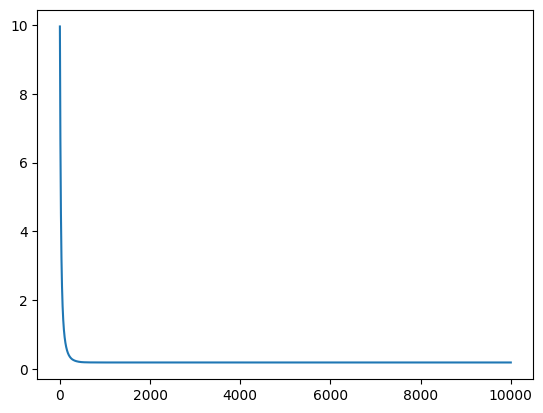

In [357]:
plt.plot(range(n_iterations), cost_history)
plt.show()

### 14) Evaluation du modèle - Coefficient de détermination

In [358]:
def coef_determination(y, pred):
    u = ((y - pred)**2).sum()
    v = ((y - y.mean())**2).sum()
    return 1 - u/v

In [359]:
print("Le coefficient de determination de notre modèle est : ",coef_determination(Y_test_norm, predictions))

Le coefficient de determination de notre modèle est :  0.6330354707479726
